In [ ]:
import jax.numpy as jnp
import jax
from jax import random, jit
from jax.config import config
import numpy as np
import matplotlib.pyplot as plt

import encoding
import encryption
import keygen
from interpreter import homomorphic

config.update('jax_enable_x64', True)

In [2]:
# ciphertext polynomial degree
n = 32

# bits precision of decimal
delta = 1 << 4

# bits precision of integer + bits precision of decimal
q0 = 1 << 8

# number of multiplications
n_mult = 4

# ciphertext modulus
q = q0*(delta**n_mult)

# relinearization modulus
p = 1 << 25
print(f'n={n}, q={q}, delta={delta}, p={p}, n_mult={n_mult}')

n=32, q=16777216, delta=16, p=33554432, n_mult=4


In [3]:
def f1(x):
    return x*x*x - 3*x*x - x + 4


def f2(x):
    return  -x*(x - 4) + 3*x*(x - 2)*(x + 2) + 4 - 2 + x

def f3(x):
    return jnp.exp(x) - 6

# Select a function to run homomorphically:

In [4]:
f = f1

# Run and visualize the output of the homomorphic function

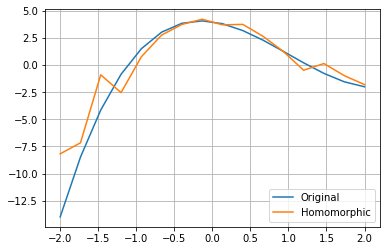

In [5]:
# JAX requires you input random seeds to all functions requiring some randomness.
# Generate these seeds:
key = jax.random.PRNGKey(5)
key, keygen_key, encoding_key = random.split(key, 3)

# Run Keygen
pk, sk, ek = keygen.keygen(keygen_key, n, q, p)

# Encode and Encrypt and input numpy array `x`
x = np.linspace(-2,2,n//2)
x_pt = encoding.encode(encoding_key, x, delta)
x_ct = encryption.encrypt(x_pt, pk, q, n)

# Apply the homomorphic function transformation producing a homomorphic function `f_he`
# Note that the homomorphic function outputs a ciphertext and a ciphertext modulus `q_out` used for decryption
f_he = homomorphic(f, p=p, q=q, n=n, ek=ek, delta=delta, n_mult=n_mult, order=3)
y_ct, q_out = f_he(x_ct)

# Decrypt and Decode the result of the homomorphic function
y_pt = encryption.decrypt(y_ct, sk, q_out, n)
y_approx = encoding.decode(y_pt, delta, n)

plt.plot(x, f(x), label='Original')
plt.plot(x, y_approx, label='Homomorphic')
plt.legend()
plt.grid()

# Benchmark Performance

First apply the `jax.jit` and `homomorphic` transformations. 

Note that the first time a jit-ed function is run, there is added time to do the compilation. This is the reason the jit-ed functions are called once before benchmarking.

Also note that jit-ing the homomorphic function can take some time so be patient.

In [6]:
f_jit = jax.jit(f)

f_he = homomorphic(f3, p=p, q=q, n=n, ek=ek, delta=delta, n_mult=n_mult, order=3)
f_he_jit = jax.jit(f_he)

_ = f_he_jit(x_ct)
_ = f_jit(x)

Benchmark each of the functions with `timeit`

In [9]:
%%timeit
_ = f_he(x_ct)

3.96 s ± 31.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
_ = f_he_jit(x_ct)

485 µs ± 748 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
%%timeit
_ = f(x)

2.73 µs ± 4.83 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [8]:
%%timeit
_ = f_jit(x)

1.77 µs ± 28.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
